Now we have finally reached detrending. This part is both the easiest and most complicated part. Detrending in itself is a fairly simple procedure, but how do we determine what parameters we should detrend on? Moreover, what order should we use to detrend? The best would be to detrend everything at the same time. Unfortunately, no one has figured out a good way of doing this (though not for lack of trying). We will go over these things in detail in this tutorial.

As always import necessary modules

In [1]:
#basic packages

import numpy as np
import copy 
import scipy.interpolate as scInterp

import matplotlib.pyplot as plt

import statsmodels.api as sm


# BRITE routines

from BRITE_decor.inout import load_alt as load
from BRITE_decor.analysis import extra as be

import BRITE_decor.detrending.detrendPositionFlux as POSdetrendBRITE
import BRITE_decor.detrending.detrendTempFlux as TEMPdetrendBRITE
import BRITE_decor.detrending.detrendTempFlux as ORBdetrendBRITE
#enable inline plots
%matplotlib inline

The first thing we will do is load the data, just like we have done so many times before.


In [2]:
filename = 'HD37043_OrionI-2013_UBr_setup7_opsfrem.dat'

data,  columns, params = load.load_dataset(filename)

show_ME = False


Right, so before we do anything let's discuss the parameters we can actually use for detrending. Many of them we have seen in previous tutorials, but some we haven't. They are as follows:

1.) Temperature
2.) X Position
3.) Y Position
4.) Orbital Phase
5.) Orbital Temperature


Most of these we have seen before except 4 and 5. We also don't have these parameters yet, so let's maker them and add them to our data array. First we want toexpress all our times as a function of where the fall in the orbit. This is important as you might have instrumental effects which reoccur as orbits.

This requires us to define a few parameters first. Then we can do our conversion.


In [3]:
per = {'UBr':100.3708/1440., 'BAb':100.3617/1440., 'BTr':98.2428/1440., 'BLb':99.6651/1440., 'BHr':97.0972/1440.} #dictionary with all of the satellite orbital periods.

sat = params['SatellID']
orbper = per[sat]
t0 = 0.0 #we have no reason to define it at a specific value, so we will just leave it at 0

orbph = (data[:,0]-t0)/orbper #turn time into orbital cycles
Phase = abs(orbph-np.floor(orbph)) #and then into phase
#plt.plot(Phase, fluxCORRECTED, '.', ms=0.5)
data = np.column_stack((data, Phase))
columns['Phase'] = 8


Next we want orbital temperature. So what does this really mean? Well we know that the data changes as a function of temperature, and what will dominate this (most likely) is the long term trend. But the temperature changes in a predictable way every orbit and that may be hard to see with the long term trend. It could be also that this is comparable to orbital phase, but it's worth looking at. To do this we need the temeperature with the long term trend removed, by using our handy lowess filter for what probably seems like the 100th time. In fact, since this takes a while to run, you may just want to save the output from earlier andjust load it here. I have not done this because I want the tutorial to be as transparent as possible, but for your own coding needs you may find this useful.



In [4]:
temp = data[:,columns['CCDT']]
HJD = data[:,columns['HJD']]

TPOSlowess = sm.nonparametric.lowess(temp, HJD, frac=0.1, delta=0.1)
time_l, TPOS_l = TPOSlowess[:,0], TPOSlowess[:,1]

Orbtemp = temp-TPOS_l
data = np.column_stack((data, Orbtemp))
columns['Orbtemp'] = 9


Now let's print all our flux vs. parameter correlations to see what we are dealing with.

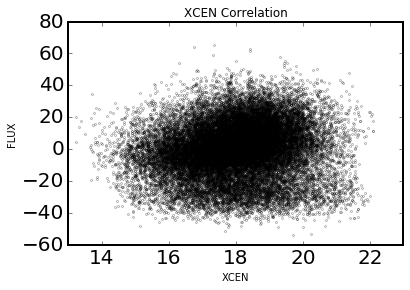

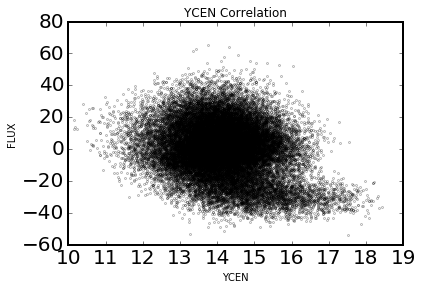

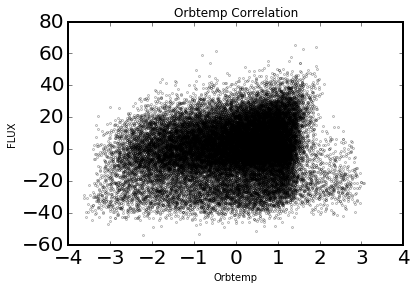

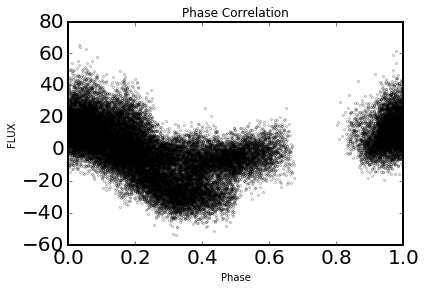

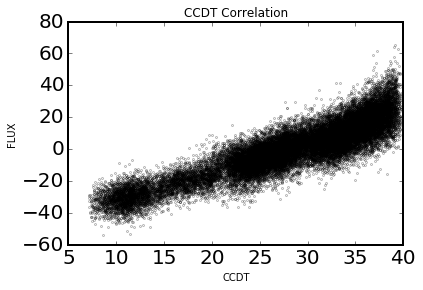

In [5]:
for x in columns:

    if x not in ['FLUX', 'exptime', 'stack', 'JD', 'HJD'] :

        plt.figure()
        plt.title(str(x)+' Correlation')
        plt.plot(data[:,columns[x]], data[:,columns['FLUX']], 'k.', ms=0.5)
        plt.ylabel('FLUX')
        plt.xlabel(x)

plt.show()


Okay, we learned a few things right off the bat. 

1.) There is a strong correlation with temperature (which we kind of expected), that needs to be corrected. 
2.) X and Y don't matter a lot, which considering the corrections we made is not a surprise (though there is a weird tail in the Y that we can consider later).
3.)Phase is clearly important, but it's clear there is not just one correlation, so we are going to have to figure out how to deal with this. 
4.) Orbtemp seems to have some weird things going on. Right now, it is unclear, but perhaps we can tell more after we remove the long term temperature trend.


So it seems like the obvious thing to correct is temperature in this case, but this may not always be a given. Remember that we are looking at Orion I (the comminssiong field), which had much higher temperature swings than any other observation field, because efforts to stabilize the temperature had not been implemented yet. To make this decision easier, let's calculate the covariance of all the parameters. To do that we could use our whole data array, but a lot of columns are useless to us. Luckily we have a convenience function which will help with this. 


In [6]:
col = [columns['FLUX'], columns['XCEN'], columns['YCEN'], columns['CCDT'], columns['Phase'], columns['Orbtemp']]
names = ['FLUX', 'XCEN', 'YCEN', 'CCDT', 'Phase', 'Orbtemp']

be.corr_strength(data, col, names, plot=show_ME)

[2 1 4 0 3]
[1, 2, 3, 4, 8, 9]
CCDT 0.888511203437
YCEN -0.252242208719
Orbtemp 0.165033769899
XCEN 0.10291918371
Phase 0.00345183869931


(4, 0.88851120343745638)

Things are more or less as we expected with the exception of phase. The correlation with phase seems fairly obvious by eye, but bascially makes no appearance in the covariance matrix. This is likely due to the fact that there are several different correlations which appear to be reducing the correlation strength quite severely. It's hard to tell how exactly we should deal with this, but what isn't hard to tell at all is that temperature is clearly the most impactful, so let's take care of it first.

In [7]:
FLUX= data[:,columns['FLUX']]
TEMPcorrection = be.param_detrend(HJD, FLUX, temp, name='temp', show_ME=show_ME)
fluxCORRECTED = FLUX - TEMPcorrection


That was relatively painless. tckTEMPcorrection is the spline fit data, Tempcorrection, the actual correction for the flux, which we then subtracted off to get the corrected flux. This can actually affect our correlations, so let's see whatour covariance matrix looks like now.


In [8]:
col = [columns['FLUX'], columns['XCEN'], columns['YCEN'], columns['CCDT'], columns['Phase'], columns['Orbtemp']]
names = ['FLUX', 'XCEN', 'YCEN', 'CCDT', 'Phase', 'Orbtemp']

datan = np.copy(data)
datan[:,1] = fluxCORRECTED

be.corr_strength(datan, col, names, plot=show_ME)


[3 0 4 1 2]
[1, 2, 3, 4, 8, 9]
Phase -0.079515600003
XCEN -0.054059823058
Orbtemp -0.0474117789754
YCEN 0.0306596656036
CCDT 1.5078974158e-11


(8, 0.079515600003019896)

And...wow. That may have been a little unexpected. Phase correlations are almost completely gone, but all other correlations are even smaller. So let's try to correct the Phase and see what happens. 

In [10]:
PHASEcorrection = be.param_detrend(HJD, fluxCORRECTED, Phase, name='Phase', show_ME=show_ME)
fluxCORRECTEDph = fluxCORRECTED - PHASEcorrection

It didn't appear to change a lot, but let's overplot just to see.

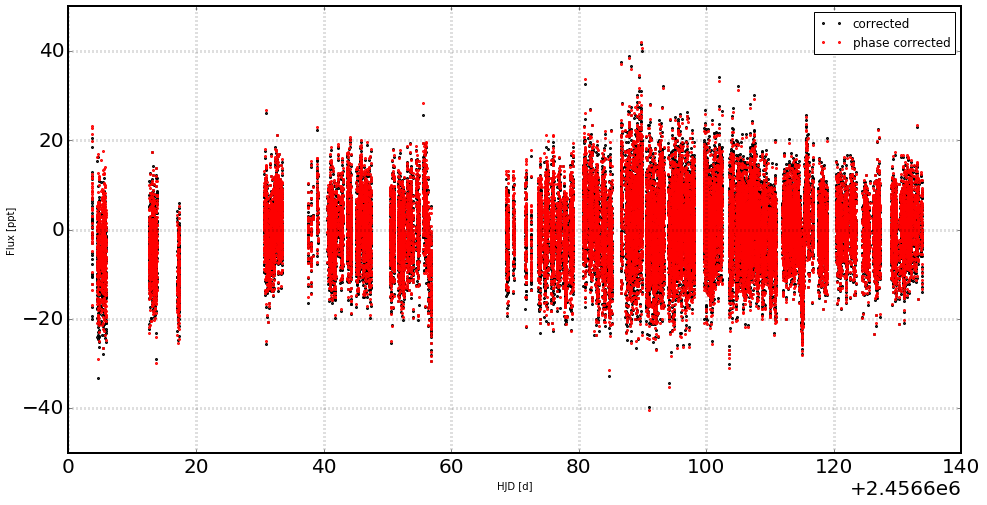

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(HJD, fluxCORRECTED, 'k.', ms=2.0, label='corrected')
plt.plot(HJD, fluxCORRECTEDph, 'r.', ms=2.0, label='phase corrected')
plt.grid(color='k', lw=3, alpha=.25)
plt.xlabel('HJD [d]'); plt.ylabel('Flux [ppt]')
plt.legend()

plt.show()

Well, it doesn't help much if at all So we can probably ignore it. Okay, we are basically Done. What correlations you consider worth correcting are up to you. However, in my personal opinion they should be around 0.1 (you can go to 0.01 but it seems unlikely to be helpful. We do have one more thing to consider though. Remember earlier when I said we might have to cut the data because correlations can change with time (or temperature, which is effectively the same thing in this case)? Well, we should make sure that there are no obvious correlations that we are missing. So let's split the data on the only thing we can currently which is time gaps. This data set has several big gaps so we'll make the gapsize 3.5 days.

0.0 2.24397374317 1.0
7.02
9.00535286171 10.1988828643 0.0
6.84
13.4730725433 13.7580968188 0.0
5.95
27.0181178111 29.8758557229 1.0
7.08
33.9926993549 43.8233124972 2.0
7.05
46.7441780302 53.2434386183 2.0
6.88
64.9676592834 130.183296693 16.0
7.87


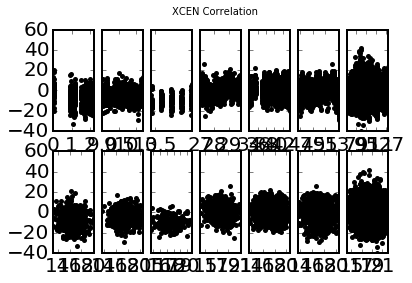

0.0 2.24397374317 1.0
5.06
9.00535286171 10.1988828643 0.0
5.02
13.4730725433 13.7580968188 0.0
4.92
27.0181178111 29.8758557229 1.0
5.13
33.9926993549 43.8233124972 2.0
5.56
46.7441780302 53.2434386183 2.0
5.36
64.9676592834 130.183296693 16.0
7.04


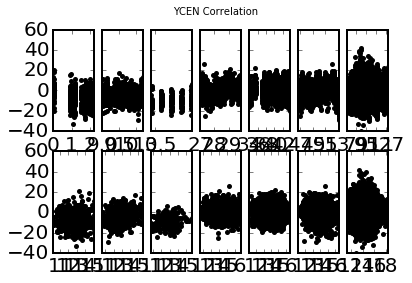

0.0 2.24397374317 1.0
4.71
9.00535286171 10.1988828643 0.0
4.5
13.4730725433 13.7580968188 0.0
4.28
27.0181178111 29.8758557229 1.0
4.8
33.9926993549 43.8233124972 2.0
6.7
46.7441780302 53.2434386183 2.0
7.21
64.9676592834 130.183296693 16.0
32.58


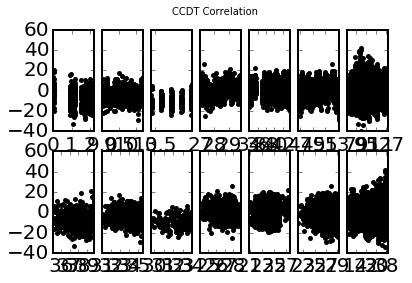

0.0 2.24397374317 1.0
0.193847119808
9.00535286171 10.1988828643 0.0
0.998522542417
13.4730725433 13.7580968188 0.0
0.151503361762
27.0181178111 29.8758557229 1.0
0.328558757901
33.9926993549 43.8233124972 2.0
0.322958394885
46.7441780302 53.2434386183 2.0
0.243605174124
64.9676592834 130.183296693 16.0
0.999964416027


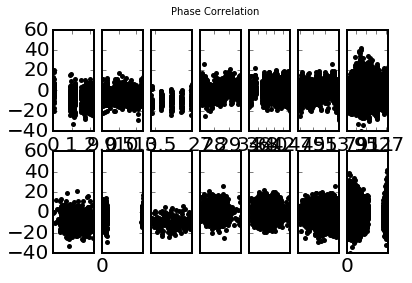

0.0 2.24397374317 1.0
4.52936799669
9.00535286171 10.1988828643 0.0
4.55945523865
13.4730725433 13.7580968188 0.0
4.34154283177
27.0181178111 29.8758557229 1.0
4.97944663787
33.9926993549 43.8233124972 2.0
6.12209972962
46.7441780302 53.2434386183 2.0
4.85969405198
64.9676592834 130.183296693 16.0
6.68388595236


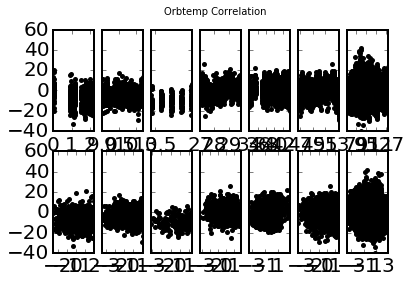

In [13]:
datan = np.copy(data)
datan[:,1] = fluxCORRECTED
indices = be.ind_split(HJD, gapsize=2.5) # find the indices on which to split data
datasplit = be.array_split(datan, indices) #list of arrays split on gap size.

for x in range(1, len(col)):#add the one because we don't need flux
    plotcols=[0,1,col[x]]
    be.plot_trends(datasplit, plotcols, title=names[x])


Okay, There are definitely correlations that we missed, but going through each individual set like this would take forever and I'm not about that life.  Instead, let's cycle through each of the small data chunks and use an auto_detrend to pick which correlations to do. However, when we do this, we must provide the level of correlation to correction. I would put this at 0.1. For the smaller chunks I would not go much below this because it's easy to overcorrect with small numbers of data points.


In [15]:
datasplitCORRECTED = []
for x in range(len(datasplit)):
    
    print "Split number", x
    col = [columns['FLUX'], columns['XCEN'], columns['YCEN'], columns['Phase'], columns['Orbtemp']]
    data_chunk = datasplit[x]
#    plt.plot(data_chunk[:,columns['HJD']], data_chunk[:,columns['FLUX']], 'k.', ms=0.5)
    flux = be.auto_detrend(data_chunk, col, columns, mincorr=0.1, plot=show_ME)
    data_chunk[:,columns['FLUX']] = flux
    datasplitCORRECTED.append(data_chunk)

datan2 = np.vstack((datasplitCORRECTED))


Split number 0
[0 2 3 1]
[1, 2, 3, 8, 9]
XCEN -0.102920519336
Phase -0.083184128815
Orbtemp -0.0737676847906
YCEN 0.0458339269123
2 0.102920519336
Correcting for XCEN
[0 1 2]
[1, 3, 8, 9]
YCEN 0.0690932930794
Phase -0.0356134990207
Orbtemp -0.0242493460853
3 0.0690932930794
Split number 1
[1 3 0 2]
[1, 2, 3, 8, 9]
YCEN 0.225731670402
Orbtemp -0.0825179613163
XCEN 0.0620014011015
Phase 0.061469251856
3 0.225731670402
Correcting for YCEN
[2 0 1]
[1, 2, 8, 9]
Orbtemp 0.03795990008
XCEN 0.0333337728147
Phase -0.0297287948963
9 0.03795990008
Split number 2
[1 3 0 2]
[1, 2, 3, 8, 9]
YCEN 0.135293730473
Orbtemp -0.0251475087268
XCEN 0.0238240994568
Phase -0.0117476900248
3 0.135293730473
Correcting for YCEN
[1 2 0]
[1, 2, 8, 9]
Phase 0.0593579472636
Orbtemp 0.0537953660945
XCEN -0.0161537658771
8 0.0593579472636
Split number 3
[0 2 1 3]
[1, 2, 3, 8, 9]
XCEN -0.172143073415
Phase -0.119276383428
YCEN -0.0948289165113
Orbtemp -0.0655953237883
2 0.172143073415
Correcting for XCEN
[0 1 2]
[1, 3, 

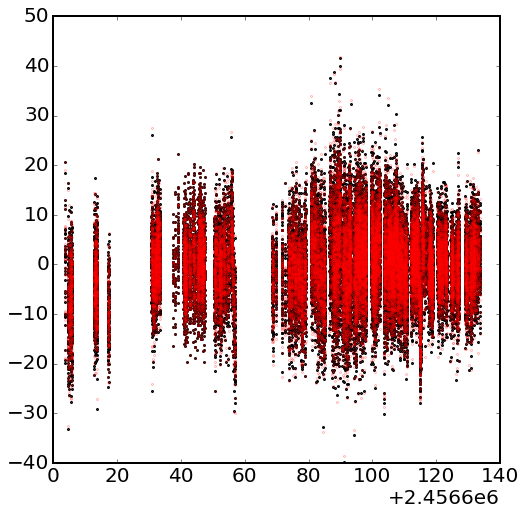

In [16]:
plt.figure(figsize=(8,8))
plt.plot(HJD, fluxCORRECTED, 'k.', ms=2.0)
plt.plot(HJD, datan2[:,columns['FLUX']], 'r.', ms=0.5)
plt.show()


Now Let's see how our correlations look after corrections.

[2 0 1 3]
[1, 2, 3, 8, 9]
CCDT -0.0827923563057
XCEN 0.0329614568222
YCEN 0.0231195521386
Phase -0.00957282803409


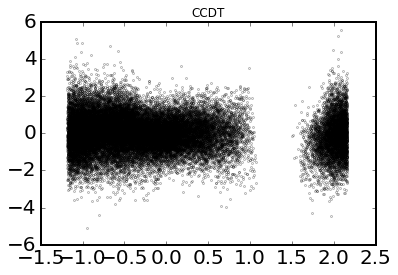

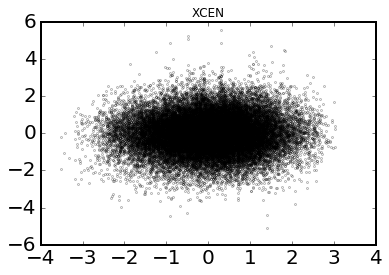

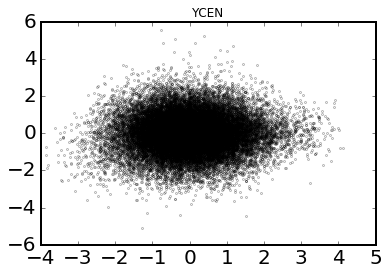

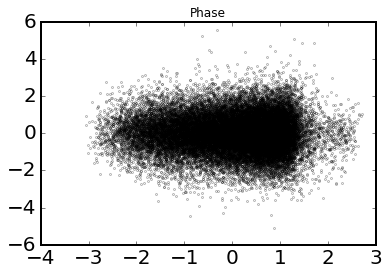

(8, 0.082792356305735601)

In [17]:
be.corr_strength(datan2, col, names, plot=True)

And with that we are done with detrending, or at least as done as we are able to get at this particular stage. You can play around with this some more. If there are some things that just don't seem right, or that you feel can be better corrected, change a parameter or 2. Split on a smaller gap size, or take a smaller correlation strength. Each dataset has some unique points, as will certain satellites. We'll save the data set and finish up. Have fun exploring and good luck!

In [18]:
targ = params['StarInFo'].split(',')[0]
obsid= params['FieldIDn'].split('_')[1]
tel = params['SatellID']
setup = params['IFilSetN']

filename = str(targ)+'_'+str(obsid)+'_'+str(tel)+'_'+str(setup)+'_opremdet.dat'

load.save_dataset(filename, datan2, columns=columns, params=params)

There is no column "FLAG" to delete
